# Decoding Representations in Deep Networks


Decoding representations in the different layers of a deep network is a very valuable machine learning excercise.
Usually one wants to decode a stimulus category or the continuous value of one of its parameters, such as luminosity, eccentricity, position etc.

The steps are :

- train a linear classifier or a linear regression algorithm
- assess its performance

This operation entails hyperparameters search with cross-validation


In [1]:
# imports

import os
import os.path as path
from os import listdir 
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import h5py

from keras.datasets import mnist
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras import backend as K

from tqdm import tqdm

Using TensorFlow backend.


# Load data, model and extract representations

We repeat the steps in the preceding exercise first

In [2]:
(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_test_int = l_test # keep labels in integer form
l_train, l_test = to_categorical(l_train), to_categorical(l_test)

In [3]:
# extract a random sample of n_sample elements from each category in test set

n_samples = 100
samples = np.zeros((n_samples*10,28,28,1))
labels = np.zeros((n_samples*10,))
labels_int = []
for i in range(10):
    labels_int.append([i]*n_samples)
    mask = l_test_int == i
    temp_i_test = i_test[mask]
    idx = np.random.permutation(temp_i_test.shape[0])[:n_samples]
    samples[i*n_samples: (i+1)*n_samples,:,:,:] = temp_i_test[idx]
    labels[i*n_samples: (i+1)*n_samples] = np.zeros((n_samples,)) + i
labels = to_categorical(labels)

In [4]:
labels_int = np.asarray(labels_int).flatten()

In [5]:
model = load_model(join('models', 'mlp3.h5'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
def extract_representations(model,samples):
    inp = model.input                                           # input placeholder
    outputs = [layer.output for layer in model.layers]          # all layer outputs
    functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function
    layers_outs = functor([samples, 1.])
    return layers_outs

In [7]:
layers_outs = extract_representations(model,samples)

In [8]:
layers_names = [l.name for l in model.layers]

In [9]:
layers_names

['images', 'flatten_1', 'hidden1', 'hidden2', 'hidden3', 'output']

In [10]:
# print names
_ = [print(l_name, l_out.shape) for l_name,l_out in zip(layers_names, layers_outs)]

images (1000, 28, 28, 1)
flatten_1 (1000, 784)
hidden1 (1000, 100)
hidden2 (1000, 100)
hidden3 (1000, 100)
output (1000, 10)


In [11]:
ind_to_extract = [0,2,3,4,5]
layers_labels = ['images', 'hidden1', 'hidden2', 'hidden3', 'output']

# Decoding of Representations in a Layer

In [12]:
# flatten representations
layers_outs = [np.reshape(l, (n_samples*10, -1)) for l in layers_outs]

# print names
_ = [print(l_name, l_out.shape) for l_name,l_out in zip(layers_names, layers_outs)]

images (1000, 784)
flatten_1 (1000, 784)
hidden1 (1000, 100)
hidden2 (1000, 100)
hidden3 (1000, 100)
output (1000, 10)


In [13]:
layers_info = zip(layers_names, layers_outs)

In [14]:
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing

In [15]:
from sklearn.metrics import make_scorer, balanced_accuracy_score
from scipy.stats import pearsonr

def discrete_variable_score(y_true, y_predicted):    
    return balanced_accuracy_score(y_true, y_predicted)

def continuous_variable_score(y_true, y_predicted):
    return pearsonr(y_true,y_predicted)[0]

In [16]:
# create scorer
my_func = make_scorer(discrete_variable_score,greater_is_better=True)

In [17]:
Score = []
Results = []
Parameters = []


Cs = np.power(10., np.arange(-3,3))
#Cs = [0.01]

# define grid of parameters
param_grid = {'C' : Cs}
nresampling = 10
nfolds = 5
nprocs = 1


y = labels_int

for i in tqdm(ind_to_extract):
    
    X = layers_outs[i]
    
    # preprocessing
    #X = preprocessing.scale(X) 
    
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=None)
    
    # basis classifier
    clf_ = SVC(kernel='linear')
    
    grid_search = GridSearchCV(clf_, param_grid, 
                                scoring=my_func, 
                                cv=nfolds, 
                                n_jobs=nprocs, 
                                refit=True,
                                return_train_score=True)

    grid_search.fit(X_train, y_train)    
    
    
    Score.append(grid_search.best_score_)             
    Results.append(grid_search.cv_results_)
    Parameters.append(grid_search.best_params_['C'])

 20%|██        | 1/5 [00:25<01:42, 25.60s/it]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
 80%|████████  | 4/5 [00:33<00:10, 10.31s/it]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
100%|██████████| 5/5 [00:33<00:00,  7.35s/it]


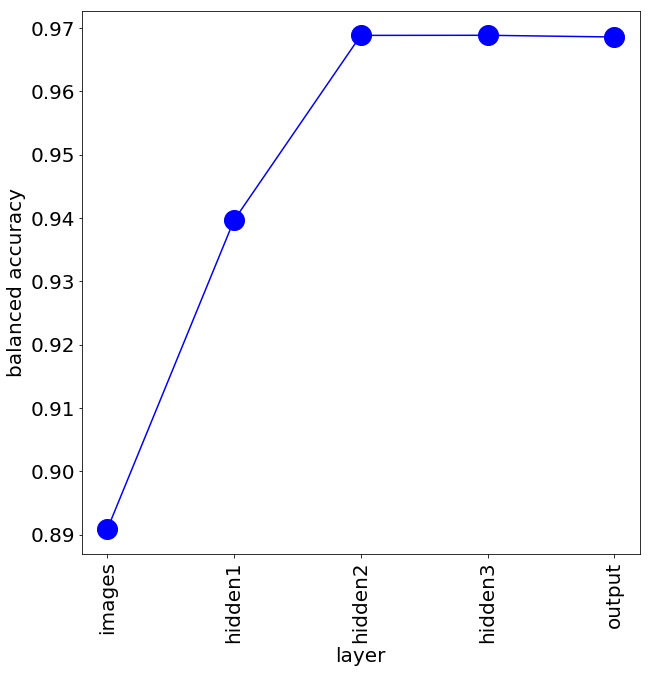

In [18]:
fs = 20
ms = 20

fig = plt.figure(figsize=(10,10))
plt.plot(range(len(ind_to_extract) ), Score, '-bo',markersize=ms) 
plt.xticks(range(len(ind_to_extract) ), 
           layers_labels, 
           rotation='vertical',
           fontsize=fs)

plt.yticks(fontsize=fs)
plt.ylabel('balanced accuracy',fontsize=fs)
plt.xlabel('layer',fontsize=fs)
plt.show()

# CIFAR-10

In [19]:
import numpy as np
import keras
from keras import backend as K
from keras.datasets import cifar10
from cifar10vgg import cifar10vgg
from time import time


from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing

from tqdm import tqdm

In [20]:
from sklearn.metrics import make_scorer, balanced_accuracy_score
from scipy.stats import pearsonr

def discrete_variable_score(y_true, y_predicted):    
    return balanced_accuracy_score(y_true, y_predicted)

def continuous_variable_score(y_true, y_predicted):
    return pearsonr(y_true,y_predicted)[0]

In [21]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_test_int = y_test
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [22]:
model = cifar10vgg(train=False)

In [23]:
#model.model.summary()

In [24]:
n_samples = 100
samples = x_test[:n_samples,:,:,:]
labels  = y_test[:n_samples,:]
labels_int = y_test_int[:n_samples]
print(samples.shape)
print(labels.shape)

(100, 32, 32, 3)
(100, 10)


In [25]:
tin = time()
predicted_x = model.predict(samples)
print('Elapsed : {}'.format(time() - tin))

Elapsed : 3.6359164714813232


In [26]:
residuals = np.argmax(predicted_x,1)!=np.argmax(labels,1)
loss = sum(residuals)/len(residuals)
print("the validation 0/1 loss is: ",loss)

the validation 0/1 loss is:  0.05


In [27]:
np.argmax(predicted_x,1)

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
       4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
       0, 9, 3, 9, 7, 6, 9, 8, 3, 3, 8, 8, 7, 5, 5, 3, 7, 5, 6, 3, 6, 2,
       1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
       8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7])

In [28]:
np.argmax(labels,1)

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
       4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
       0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2,
       1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
       8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7])

In [29]:
layers_outs = extract_representations(model.model, samples)
layers_names = [l.name for l in model.model.layers]

In [30]:
_ = [print(i, name, l.shape) for i, (name, l) in enumerate(zip(layers_names, layers_outs) )]

0 conv2d_1 (100, 32, 32, 64)
1 activation_1 (100, 32, 32, 64)
2 batch_normalization_1 (100, 32, 32, 64)
3 dropout_1 (100, 32, 32, 64)
4 conv2d_2 (100, 32, 32, 64)
5 activation_2 (100, 32, 32, 64)
6 batch_normalization_2 (100, 32, 32, 64)
7 max_pooling2d_1 (100, 16, 16, 64)
8 conv2d_3 (100, 16, 16, 128)
9 activation_3 (100, 16, 16, 128)
10 batch_normalization_3 (100, 16, 16, 128)
11 dropout_2 (100, 16, 16, 128)
12 conv2d_4 (100, 16, 16, 128)
13 activation_4 (100, 16, 16, 128)
14 batch_normalization_4 (100, 16, 16, 128)
15 max_pooling2d_2 (100, 8, 8, 128)
16 conv2d_5 (100, 8, 8, 256)
17 activation_5 (100, 8, 8, 256)
18 batch_normalization_5 (100, 8, 8, 256)
19 dropout_3 (100, 8, 8, 256)
20 conv2d_6 (100, 8, 8, 256)
21 activation_6 (100, 8, 8, 256)
22 batch_normalization_6 (100, 8, 8, 256)
23 dropout_4 (100, 8, 8, 256)
24 conv2d_7 (100, 8, 8, 256)
25 activation_7 (100, 8, 8, 256)
26 batch_normalization_7 (100, 8, 8, 256)
27 max_pooling2d_3 (100, 4, 4, 256)
28 conv2d_8 (100, 4, 4, 512)
29 

In [31]:
# patiently individuate dropout and pooling layers indexes 
idx = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 52, 57, 59]
selected_outs = [(layers_names[i],layers_outs[i]) for i in idx]

# or use a nice list comprehension
selected_outs = [(layers_names[i],layers_outs[i]) for i in range(len(layers_names)) 
                 if 'dropout' in layers_names[i] or 'pool' in layers_names[i]]

# Decoding

In [32]:
from tqdm import tqdm

In [35]:
Score = []
Results = []
Parameters = []


Cs = np.power(10., np.arange(-3,3))
#Cs = [0.01]

# define grid of parameters
param_grid = {'C' : Cs}
nresampling = 10
nfolds = 5
nprocs = 1


y = labels_int.ravel()

for (name, representation) in tqdm(selected_outs):
    
    X = np.reshape(representation, (n_samples, -1))
    
    # preprocessing
    #X = preprocessing.scale(X) 
    
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=None)
    
    grid_search = GridSearchCV(clf_, param_grid, 
                                scoring=my_func, 
                                cv=nfolds, 
                                n_jobs=nprocs, 
                                refit=True,
                                return_train_score=True)

    grid_search.fit(X_train, y_train)    
    
    
    Score.append(grid_search.best_score_)             
    Results.append(grid_search.cv_results_)
    Parameters.append(grid_search.best_params_['C'])


  0%|          | 0/15 [00:00<?, ?it/s]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

  7%|▋         | 1/15 [00:51<12:02, 51.60s/it]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

 13%|█▎        | 2/15 [01:03<08:34, 39.57s/it]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-

In [42]:
selected_layers_labels = [l for (l,_) in selected_outs]
selected_layers_labels

['dropout_1',
 'max_pooling2d_1',
 'dropout_2',
 'max_pooling2d_2',
 'dropout_3',
 'dropout_4',
 'max_pooling2d_3',
 'dropout_5',
 'dropout_6',
 'max_pooling2d_4',
 'dropout_7',
 'dropout_8',
 'max_pooling2d_5',
 'dropout_9',
 'dropout_10']

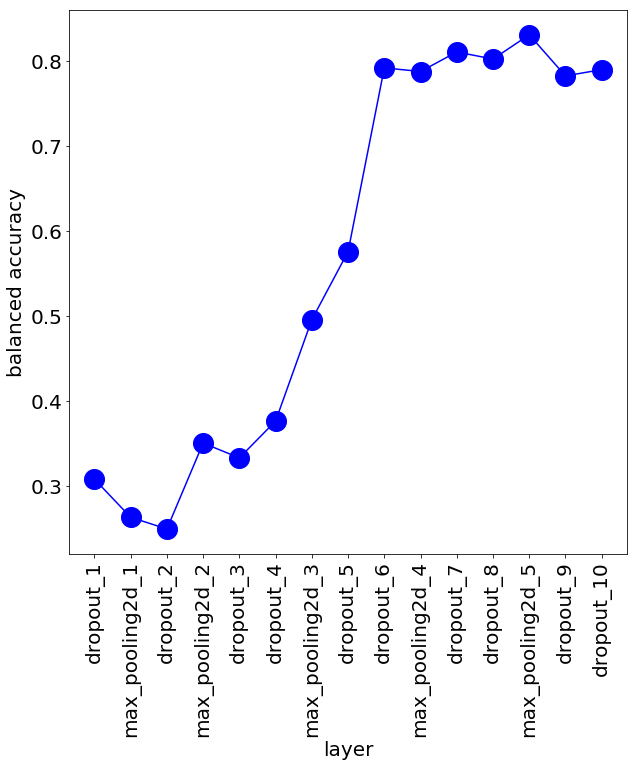

In [43]:
fs = 20
ms = 20

fig = plt.figure(figsize=(10,10))
plt.plot(range(len(selected_outs) ), Score, '-bo',markersize=ms) 
plt.xticks(range(len(selected_outs) ), 
           selected_layers_labels, 
           rotation='vertical',
           fontsize=fs)

plt.yticks(fontsize=fs)
plt.ylabel('balanced accuracy',fontsize=fs)
plt.xlabel('layer',fontsize=fs)
plt.show()